# <center>Digital Image Processing - Problem Set 2</center>

### Student Names: JORGE AGUILAR, JORGE LAMBRAÑO, JORGE DIAZ

### Instructions

This Problem Set covers the topics of Image enhancement in the spatial domain, power law transformations, histogram equalization, smoothing, median filters, image sharpening, Laplacian of an image, image gradients and Sobel operators. <br>

Your solutions to the following problems should include commented source code and a short description of each function. You should test your functions with several input images, besides the ones provided here. Include the input and output images that you used for experimentation. Analyze your results. If you discover something interesting, let us know!

### Problem 1

Implement the code for the function below, which runs histogram equalization on a grayscale image. Your code should compute the histogram of the image, and use the cdf as a transformation function. The function should return the equalized image as an array. Use the function to do histogram equalization on the images <tt>darkPollen.jpg</tt>, <tt>lightPollen.jpg</tt>, <tt>lowContrastPollen.jpg</tt>, <tt>pollen.jpg</tt>, <tt>spine.jpg</tt> and <tt>runway.jpg</tt>. Include in the report plots and comparisons between the histograms of the corrected images to those of the originals. Also include a plot of the transformation function that equalizes the input histograms. Please comment your results.

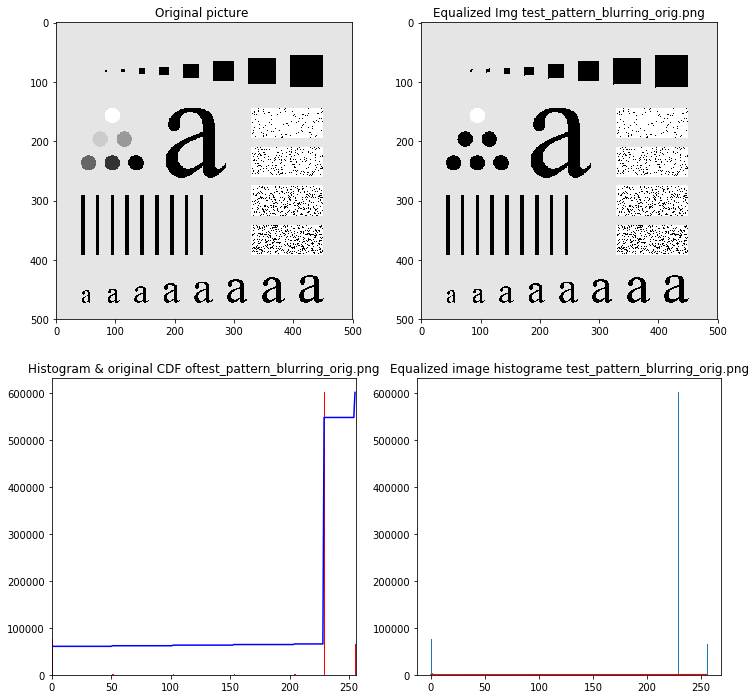

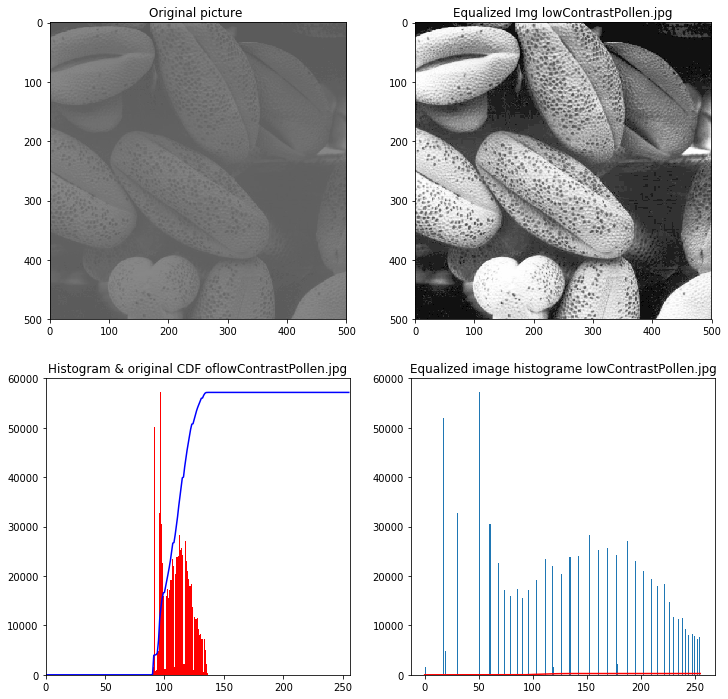

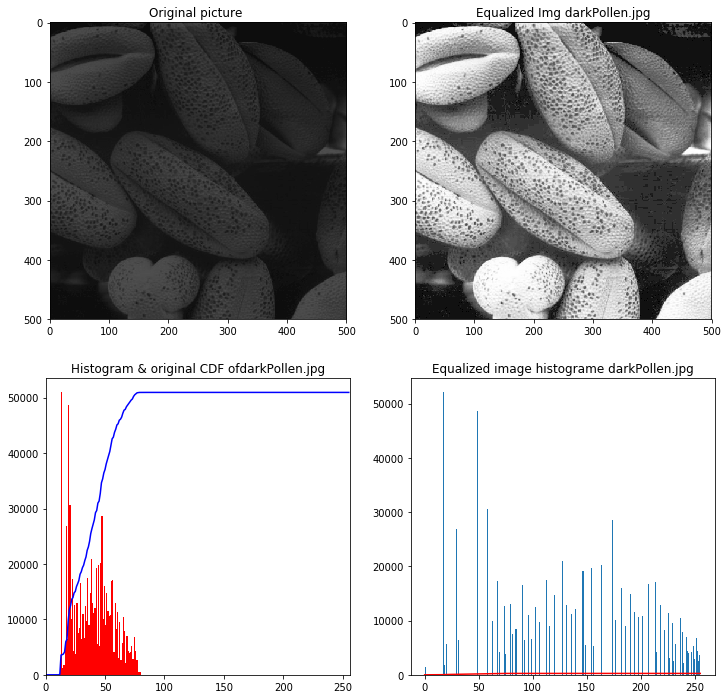

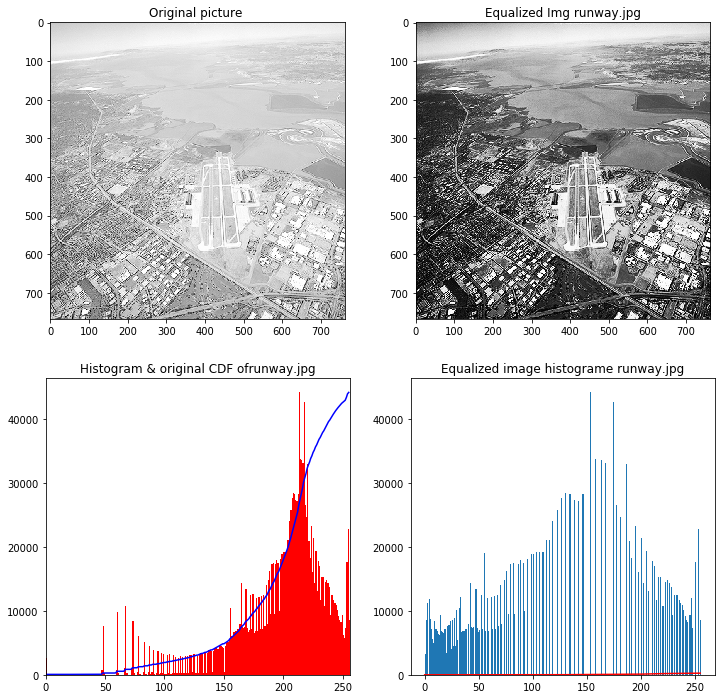

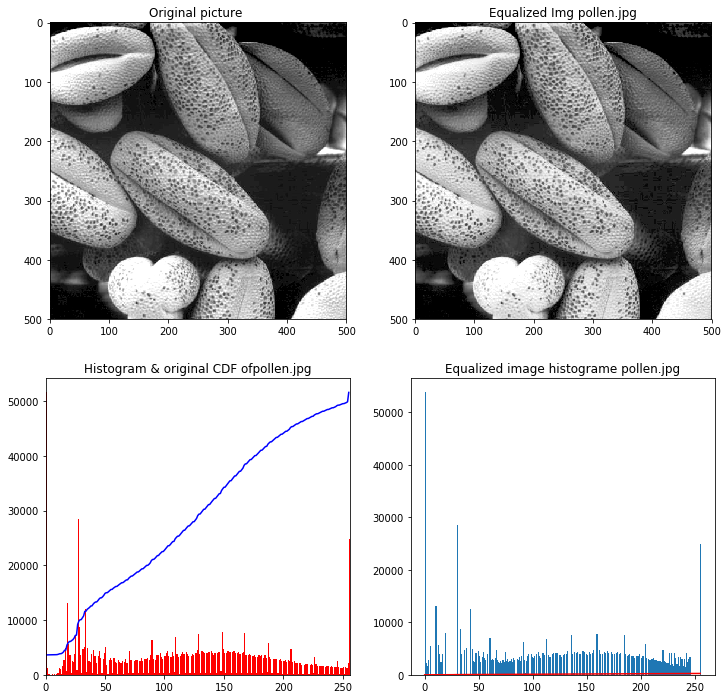

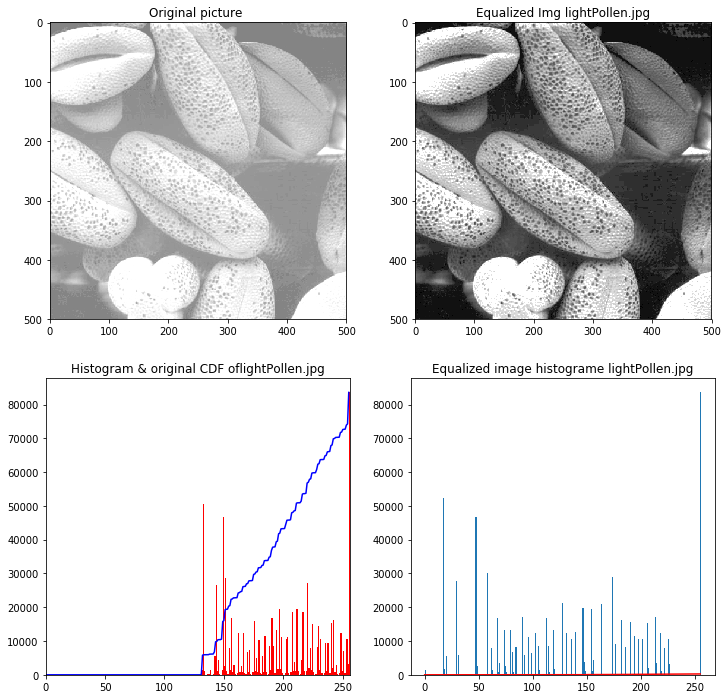

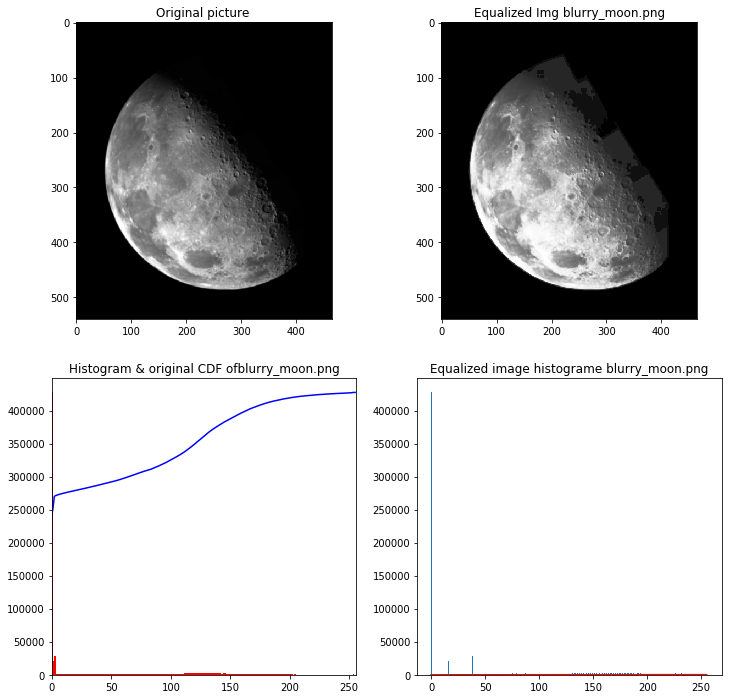

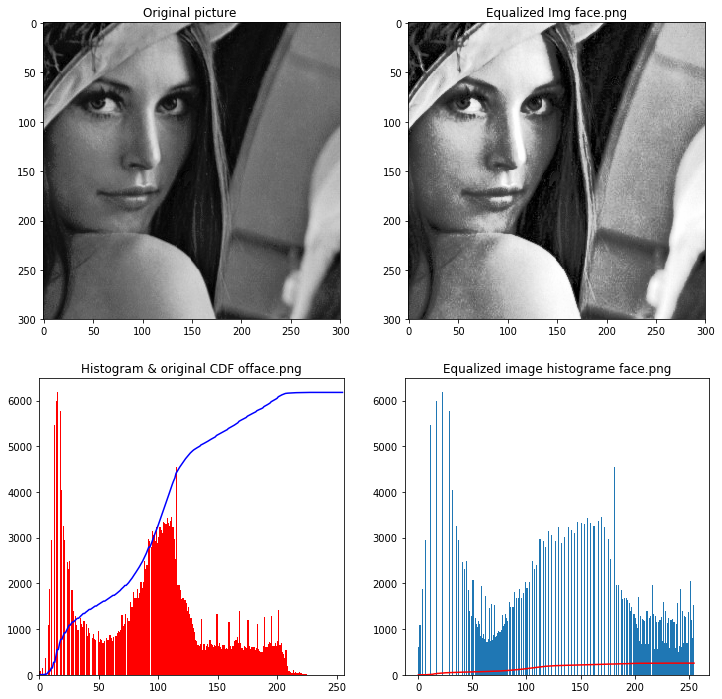

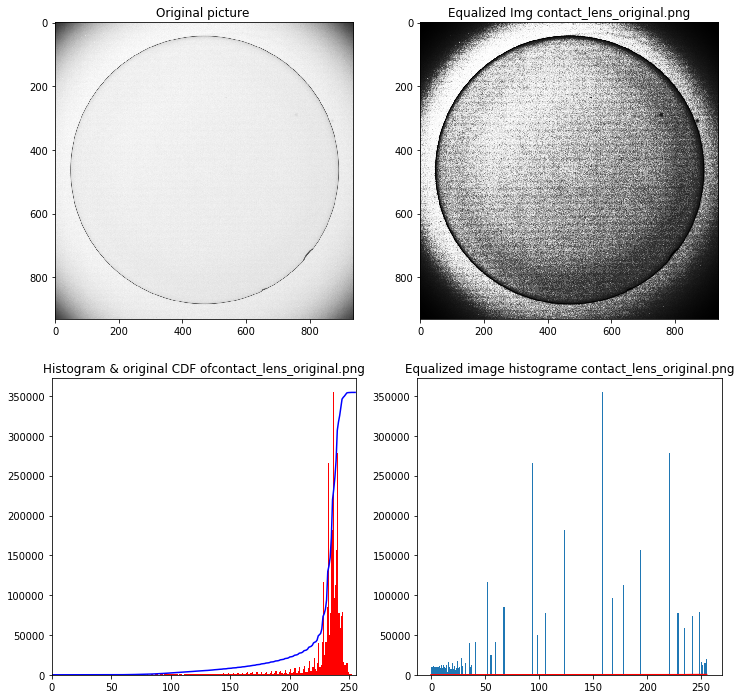

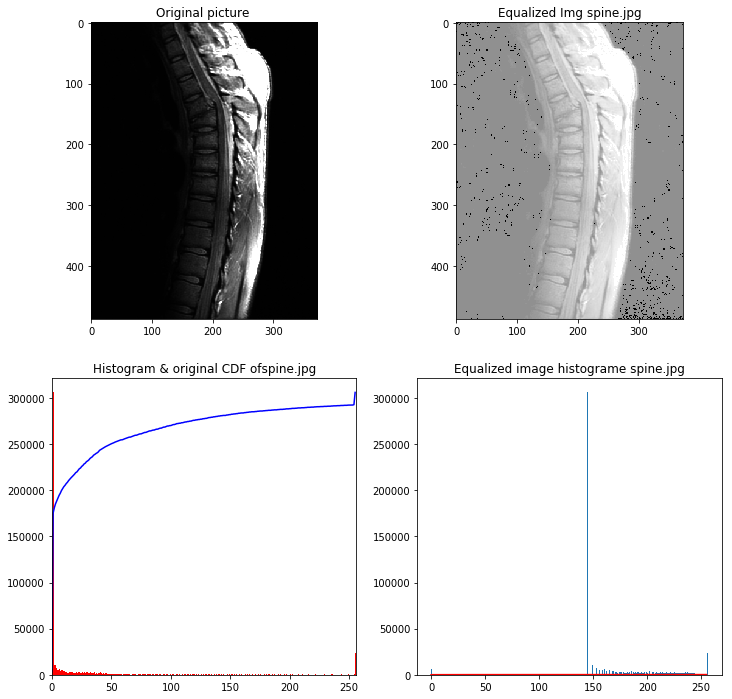

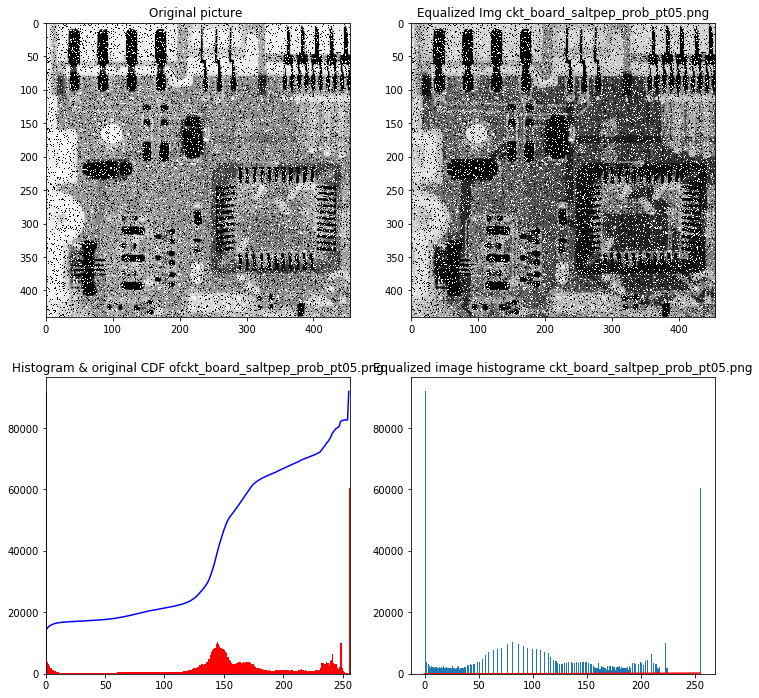

In [7]:
from os import listdir, path
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

filenames = listdir('images')

def histcdf(imgf):
    hist,bins = np.histogram(imgf.flatten(),256,[0,256]); 
    cdf = hist.cumsum()
    """The type of data was changed because an overflow was ocurring and the operation 
    realized to normalize the cdf was not working well"""
    cdf = cdf.astype(np.int64) 
    """Normalization of the CDF to have it in the same "scale" as the images histograms' values"""
    cdf_normalized = (cdf * hist.max())/ cdf.max()  
    
    """Normalized cdf plotted in blue"""
    plt.plot(cdf_normalized, color = 'b')   
    """Normal histogram plotted in red"""
    plt.hist(imgf.flatten(),256,[0,256], color = 'r')
    plt.xlim([0,256])
    plt.title("Histogram & original CDF of"+name)
    
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    """Returns the Equalized image and its CDF """
    return [cdf[img],cdf]

images = [] # List with all the images read
for i,name in enumerate(filenames):
    img = cv2.imread("images/"+name,1);
    plt.figure(figsize=(12,12));plt.subplot(2,2,1);plt.title("Original picture ");plt.imshow(img)
    plt.subplot(2,2,3);
    equa,cdfq=histcdf(img);

    plt.subplot(2,2,4)
    plt.plot(cdfq, color = 'r')  
    plt.hist(equa.flatten(),256,[0,256])
    plt.title("Equalized image histograme "+name)
    plt.subplot(2,2,2)
    plt.imshow(equa)
    plt.title("Equalized Img "+name)
plt.show();



Please comment results here.

### Problem 2

Implement the code for the function below which performs a power law transformation on an image. This function should take an image array and the gamma value to be used in the transformation as its only input parameters. The function should return a new image array which is the power transformation of the original image. Power law transformations are achieved using the following formula:
$$ g(x,y) = T[f(x,y)] = c \cdot f(x,y) ^ \gamma $$

where $g(x,y)$ is the output pixel value, $f(x,y)$ is the original pixel value, $\gamma$ is the parameter controlling the power law transformation and $c$ is a constant usually set to 1. Note that you convert the image so that the intensity values are in the range 0.0 – 1.0, rather than in 0 – 255.

Try this new function out on the images <tt>spine.jpg</tt> and <tt>runway.jpg</tt>, experimenting with different values for $\gamma$. Please comment your results.

Imagen: spine.jpg


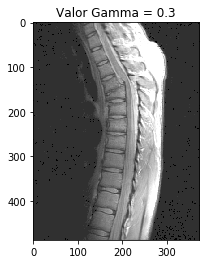

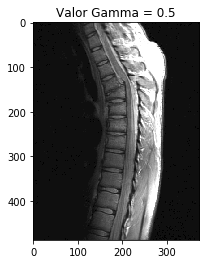

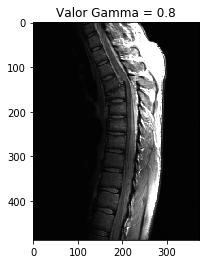

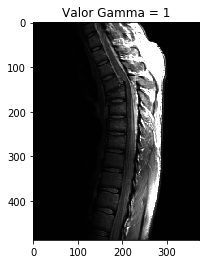

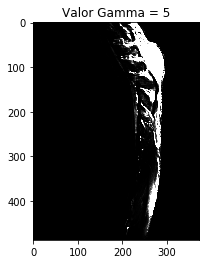

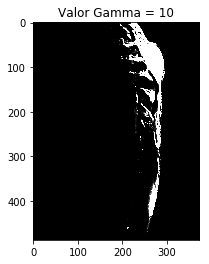

Imagen: runway.jpg


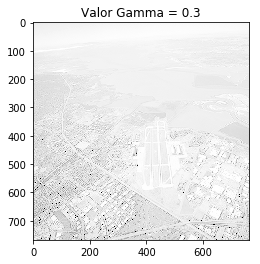

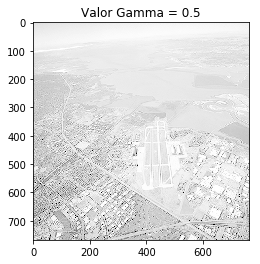

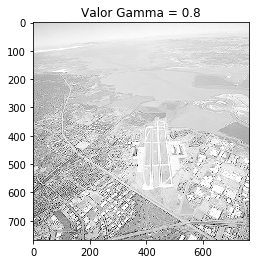

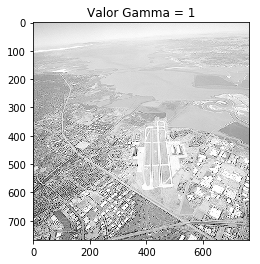

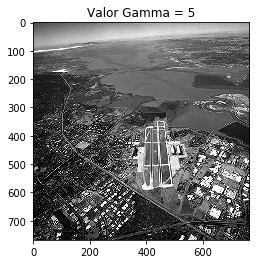

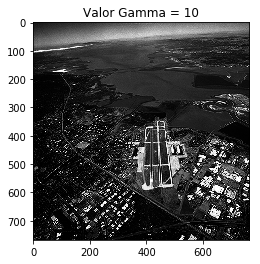

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
filenames = listdir('images')

def T_fxy(imagen, gamma):
    imagen_out = 1 * np.power(imagen/255.0,gamma)
    return (imagen_out*255).astype('int')

imagenes = ["spine.jpg", "runway.jpg"]
for nombre_imagen in imagenes:
    print ("Imagen: "+nombre_imagen)
    imagen = cv2.imread("images/"+nombre_imagen, cv2.IMREAD_GRAYSCALE)
    valores_gamma = [0.3,0.5,0.8,1,5,10] 
    for y in valores_gamma:
        plt.figure()
        plt.imshow(T_fxy(imagen,y), cmap='gray')
        plt.title("Valor Gamma = "+str(y))
    plt.show()

# (Discuss your results after looking at the resulting images)

### Problem 3

Implement a function that performs smoothing on an input image with an averaging filter mask of size $n$. The function should take two inputs: an image matrix and the filter size $n$. Use the image <tt>test_pattern_blurring_orig.tif</tt> to test your algorithm. Use averaging filter masks of sizes $n = 3, 5, 9, 15, 35$. Analyze the results you obtained.

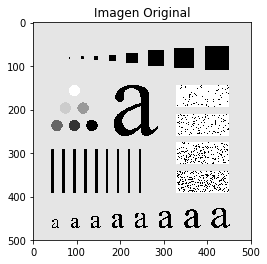

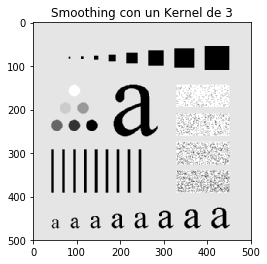

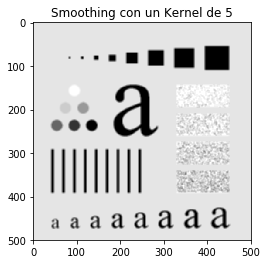

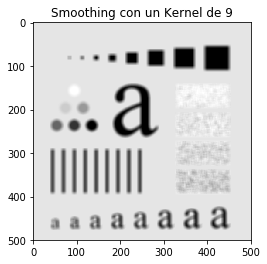

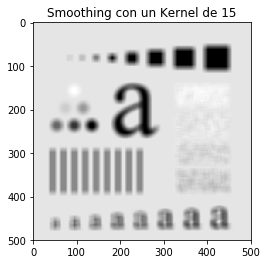

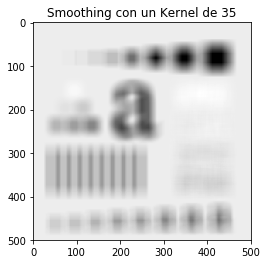

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def function_smoothing(imagen, n):
    imagen_out=cv2.blur(imagen,(n,n))
    return imagen_out

kernel_size = [3, 5, 9, 15, 35]
original_image = cv2.imread("images/test_pattern_blurring_orig.png", cv2.IMREAD_GRAYSCALE)
fig = plt.figure();
plt.imshow(original_image, cmap='gray')
plt.title("Imagen Original")
plt.show()
for i in kernel_size:
    smoothing_img = function_smoothing(original_image,i)
    plt.imshow(smoothing_img, cmap = 'gray')
    plt.title("Smoothing con un Kernel de " + str(i)) 
    plt.show()

### Problem 4

Consider the image <tt>ckt_board_saltpep_prob_pt05.png</tt>. It has been corrupted with ‘salt-and-pepper’ noise (more formally known as impulse noise). Try to remove the noise from this image by applying a median filter of size 3x3. Compare the result to applying an averaging filter of size 3x3.  Increase the kernel size to 3x3, 5x5, 9x9, 15x15 and repeat. Analyze the results you obtained. Did the filter successfully remove the noise? Did you observe any other side effects?

You can also corrupt any image you like with a salt-and-pepper noise generator. Write another function which adds salt-and-pepper noise to an input image. Use that function to corrupt additional images. Try to recover the original images using a median filter of appropriate size.

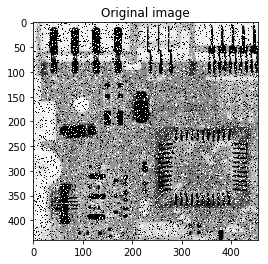

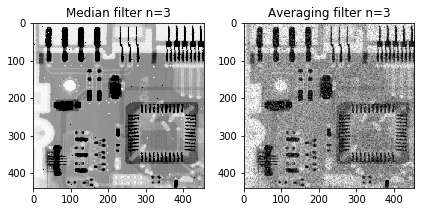

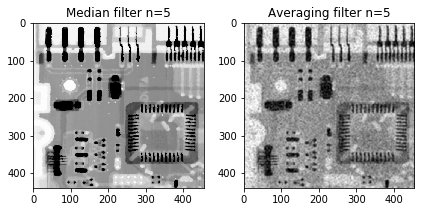

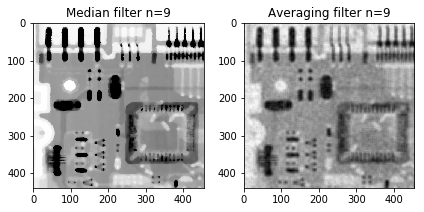

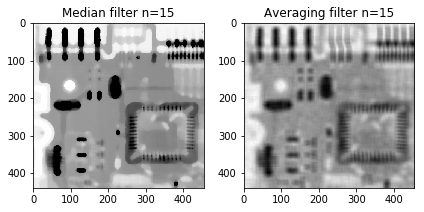

In [52]:
def noise_gen(image,percent):
    out = image.copy()
    percent = percent/100.0
    cant = int(percent/2 * image.size)
    pointsS = [np.random.randint(0, i - 1, cant) for i in image.shape]
    out[pointsS] = 255 #Salt
    pointsP = [np.random.randint(0, i - 1, cant) for i in image.shape]
    out[pointsP] = 0 #Pepper
    return out

def medianFilter(image,n):
    return cv2.medianBlur(image,n)

def avgFilter(image,n):
    return cv2.blur(image,(n,n))

img_names = ["ckt_board_saltpep_prob_pt05.png", "test_pattern_blurring_orig.png","pollen.jpg"]
img = cv2.imread("images/"+img_names[0], cv2.IMREAD_GRAYSCALE)
plt.figure(); plt.imshow(img, cmap='gray'); plt.title('Original image'); plt.show();
for n in [3,5,9,15]:
    fig = plt.figure();
    plt.subplot(1,2,1); plt.imshow(medianFilter(img,n), cmap='gray'); plt.title('Median filter n='+str(n));
    plt.subplot(1,2,2); plt.imshow(avgFilter(img,n), cmap='gray'); plt.title('Averaging filter n='+str(n));
    fig.tight_layout()
    plt.show()

test_pattern_blurring_orig.png


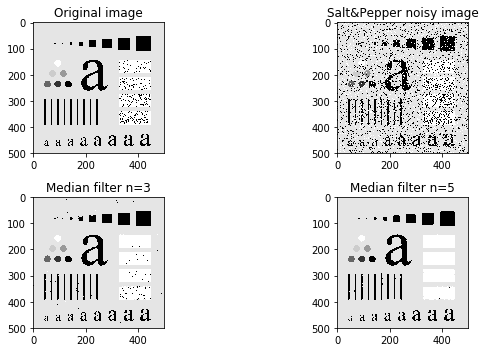

pollen.jpg


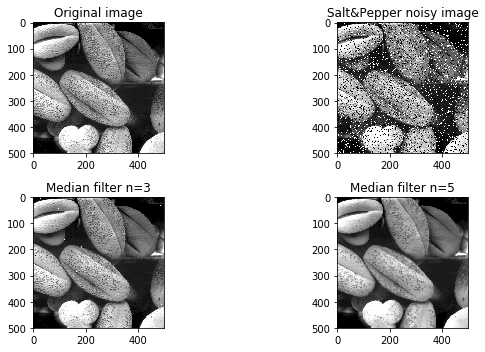

In [53]:
for name in img_names[1:]:
    print (name)
    img = cv2.imread("images/"+name, cv2.IMREAD_GRAYSCALE)
    fig = plt.figure(figsize=(10,5));
    plt.subplot(2,2,1); plt.imshow(img, cmap='gray'); plt.title('Original image');
    img_n = noise_gen(img,20)
    plt.subplot(2,2,2); plt.imshow(img_n, cmap='gray'); plt.title('Salt&Pepper noisy image');
    plt.subplot(2,2,3); plt.imshow(medianFilter(img_n,3), cmap='gray'); plt.title('Median filter n=3');
    plt.subplot(2,2,4); plt.imshow(medianFilter(img_n,5), cmap='gray'); plt.title('Median filter n=5');
    fig.tight_layout()
    plt.show()

(Discuss your results after looking at the resulting images) Analyze the results you obtained. Did the filter successfully remove the noise? Did you observe any other side effects?

### Problem 5 

`1. Write a function that sharpens an image using the Laplacian kernel. Your function should first compute the Laplacian of the input image using the following kernel:
<table>
<tr>
<td>0</td>
<td>1</td>
<td>0</td>
</tr>
<tr>
<td>1</td>
<td>-4</td>
<td>1</td>
</tr>
<tr>
<td>0</td>
<td>1</td>
<td>0</td>
</tr>
</table>

2. Visualize the Laplacian of the input image. You may consider using a power intensity transformation to enhance the Laplacian image for visualization.

3. Recall that sharpening is achieved by subtraction: $g(x,y) = f(x,y) - \nabla^2 f(x,y) $. Use this method to produce an enhanced image.

4. Recall that subtraction and filtering with a kernel are linear operations. Therefore, it is possible to combine both operations into a single kernel:
<table>
<tr>
<td>0</td>
<td>-1</td>
<td>0</td>
</tr>
<tr>
<td>-1</td>
<td> 5</td>
<td>-1</td>
</tr>
<tr>
<td>0</td>
<td>-1</td>
<td>0</td>
</tr>
</table>
Write another function that directly sharpens the image using this single kernel.

5. Finally, recall that there is an alternative kernel that can be used to compute a Laplacian: 
<table>
<tr>
<td>1</td>
<td>1</td>
<td>1</td>
</tr>
<tr>
<td>1</td>
<td> -8</td>
<td>1</td>
</tr>
<tr>
<td>1</td>
<td>1</td>
<td>1</td>
</tr>
</table>
Write another function that produces a sharpened image using a single enhancement kernel that is based on this alternative definition of the Laplacian.

Apply all the functions you wrote to the image <tt>blurry_moon.png</tt>. Compare, analyze and comment all the results. You are also encouraged to try out your functions on more testing images.

Compare, analyze and comment all the results. You are also encouraged to try out your functions on more testing images.


## Problem 6

The gradient of an image is the two-dimensional vector

$\nabla \mathbf{f} = \left[ \begin{array}{c}G_x\\G_y\end{array} \right] 
=\left[ \begin{array}{c}\frac{\partial f}{\partial x}\\ \frac{\partial f}{\partial y} \end{array} \right]
$

1. Write a function that calculates the image gradients in the $x$ and $y$ directions. Use the following Sobel operators to compute the derivatives:
<table>
<tr>
<td>-1</td>
<td>-2</td>
<td>-1</td>
</tr>
<tr>
<td>0</td>
<td>0</td>
<td>0</td>
</tr>
<tr>
<td>1</td>
<td>2</td>
<td>1</td>
</tr>
</table>
<table>
<tr>
<td>-1</td>
<td>0</td>
<td>1</td>
</tr>
<tr>
<td>-2</td>
<td>0</td>
<td>2</td>
</tr>
<tr>
<td>-1</td>
<td>0</td>
<td>1</td>
</tr>
</table>
The function should output two variables, $G_x$ and $G_y$, which correspond to the derivatives in the $x$ and $y$ directions. Visualize the resulting gradients. Analyze the results obtained. How can you interpret the gradient operators?

2. Write another function that computes the gradient magnitude of an image. Recall that the magnitude of the gradient vector can be computed by:<br>
$\nabla f = \text{mag}(\nabla \mathbf{f}) = \left[ G_x^2 + G_y^2 \right]^\frac{1}{2}$.

3. Write another function that computes an approximation of the gradient magnitude using the following equation: <br>
$\nabla f \approx |G_x| + |G_y|$. <br>
Visualize and compare the resulting gradient magnitudes computed using both methods. How can you interpret the gradient magnitude?

You may use the images <tt>contact_lens_original.png</tt> and <tt>face.png<tt> to test your algorithms.


(Discuss your results after looking at the resulting images) Analyze the results you obtained.How can you interpret the gradient operators? How can you interpret the gradient magnitude?